# Make Photoz test input from VIDEO SXDS data

This notebook uses the HELP python environment to make a CIGALE input catalogue:

https://github.com/H-E-L-P/herschelhelp_internal

to make the photoz inputs we must merge in the spectroscopic redshifts and make some trivial catalogue changes. We then need to make configuration inputs for the photoz code. This includes downloading filter response curves.

Installation and running of the EAZY based code is available here:

https://github.com/dunkenj/eazy-pype/

This is an early test on the catalogues as part of our validation process.



In [1]:

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
from herschelhelp.filters import correct_galactic_extinction
from herschelhelp.external import convert_table_for_cigale
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

import numpy as np
import os
import time

from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord

/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3

In [2]:
SUFFIX = os.environ.get('SUFFIX', time.strftime("%Y%m%d"))

In [3]:
SUFFIX

'20211011'

In [5]:
hsc_bands = 'GRIZY'
vista_bands = 'ZYJHK'
bands = ['HSC_{}'.format(b) for b in hsc_bands]
bands += ['VISTA_{}'.format(b) for b in vista_bands]
cols = ['id', 'VISTA_Ks_m_coord_ra','VISTA_Ks_m_coord_dec','VISTA_Ks_m_detect_isPrimary']
cols+=['{}_m_slot_ModelFlux_flux'.format(b.replace('K','Ks')) for b in bands]
cols+=['{}_m_slot_ModelFlux_fluxErr'.format(b.replace('K','Ks'))  for b in bands]
cat = Table.read('../../dmu5/dmu5_VIDEO/data/full_reduced_cat_SXDS.fits')[cols]
cat['VISTA_Ks_m_coord_ra'].name='ra'
cat['VISTA_Ks_m_coord_dec'].name='dec'
#Some HELP functions require a help_id col
cat['id'].name='help_id'

In [6]:
#Rename to CIGALE/HELP format
for c in cat.colnames:
    if c.endswith('m_slot_ModelFlux_flux'):
        mask = cat[c]>1e10
        cat[c][mask]=np.nan
        f_name='{}_{}_flux'.format(
            c.split('_')[0].lower(),#.replace('hsc','suprime'),
            c.split('_')[1].lower()
        )
        cat[c].name=f_name
        cat[f_name]=cat[f_name].to(u.uJy)
    if c.endswith('m_slot_ModelFlux_fluxErr'):
        mask = cat[c]>1e10
        cat[c][mask]=np.nan
        ferr_name='{}_{}_fluxerr'.format(
            c.split('_')[0].lower(),#.replace('hsc','suprime'),
            c.split('_')[1].lower()
        )
        cat[c].name=ferr_name
        cat[ferr_name]=cat[ferr_name].to(u.uJy)

In [8]:
mask = (cat['ra']<1e10) | (cat['dec']<1e10)
mask&=cat['VISTA_Ks_m_detect_isPrimary']==1
mask&=(cat['hsc_i_flux']/cat['hsc_i_fluxerr'] > 5)
mask&=(cat['vista_ks_flux']/cat['vista_ks_fluxerr'] > 5)
cat = cat[mask]
    
cat['ra']=cat['ra'].to(u.deg)
cat['dec']=cat['dec'].to(u.deg)
cat['zspec'].name='z_spec'

In [47]:
#cat['zspec'].name='z_spec'

In [10]:
!mkdir data
!wget http://hedam.lam.fr/HELP/dataproducts/dmu23/dmu23_XMM-LSS/data/XMM-LSS-specz-v2.91.fits.gz -P ./data/

mkdir: data: File exists
--2021-10-11 17:35:46--  http://hedam.lam.fr/HELP/dataproducts/dmu23/dmu23_XMM-LSS/data/XMM-LSS-specz-v2.91.fits.gz
Resolving hedam.lam.fr (hedam.lam.fr)... 195.221.212.141
Connecting to hedam.lam.fr (hedam.lam.fr)|195.221.212.141|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3391102 (3.2M) [application/x-gzip]
Saving to: ‘./data/XMM-LSS-specz-v2.91.fits.gz’

XMM-LSS-specz-v2.91 100%[===================>]   3.23M  8.07MB/s    in 0.4s    

2021-10-11 17:35:47 (8.07 MB/s) - ‘./data/XMM-LSS-specz-v2.91.fits.gz’ saved [3391102/3391102]



## Merge Specz

In [11]:
specz=Table.read('./data/XMM-LSS-specz-v2.91.fits.gz')
for c in specz.colnames:
    specz[c].name=c.lower()
specz['objid'].name='specz_id'

In [12]:
len(specz)

127682

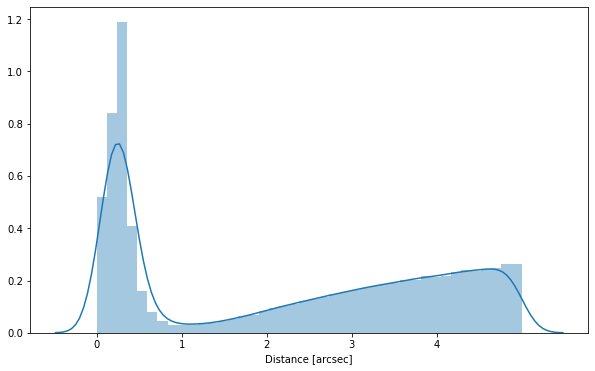

In [13]:
nb_merge_dist_plot(
    SkyCoord(cat['ra'], cat['dec']),
    SkyCoord(specz['ra'] * u.deg, specz['dec'] * u.deg)
)

In [14]:
cat = specz_merge(cat, specz, radius=1. * u.arcsec)

In [ ]:
#cat=cat[cat['specz_id']!='']
#cat['redshift']=cat['zspec']

In [ ]:
cat['hsc_r_mag']

In [15]:
len(cat)

1308739

In [16]:
cat[0:5]

help_id,ra,dec,VISTA_Ks_m_detect_isPrimary,hsc_g_flux,hsc_r_flux,hsc_i_flux,hsc_z_flux,hsc_y_flux,vista_z_flux,vista_y_flux,vista_j_flux,vista_h_flux,vista_ks_flux,hsc_g_fluxerr,hsc_r_fluxerr,hsc_i_fluxerr,hsc_z_fluxerr,hsc_y_fluxerr,vista_z_fluxerr,vista_y_fluxerr,vista_j_fluxerr,vista_h_fluxerr,vista_ks_fluxerr,specz_id,zspec,zspec_qual,zspec_association_flag
,deg,deg,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str33,float64,int64,bool
149940984795367161,34.03198792407938,-5.636746033451176,1,0.1918380120633462,0.24114609138728316,0.23910295624418496,0.3943670650640425,0.539275444256114,3.3093421221815893,0.5509247061854611,0.41870752165663716,0.3170050549873974,1.4210650305132755,0.01933043244302869,0.030078245621829574,0.027566898414982985,0.0778258370449352,0.1583567806404285,0.06724782055241774,0.024002575829053612,0.023418802960395863,0.035446290741617044,0.06803846082798298,,nan,-99,False
149940984795367228,34.03239043843923,-5.63513409597789,1,0.5193620245085407,0.8073257364329538,0.6775046773308321,1.1696392994439777,1.376104949778619,0.7212169913401356,1.1436669705612827,1.5161937043715057,0.7363723324967524,1.9766101985524038,0.022960893798619434,0.05553958305818498,0.03954325169680315,0.0898612977774623,0.19791099115015662,0.00928557764376431,0.018521803949740616,0.029229104310411657,0.03511634243528409,0.054673791964521476,,nan,-99,False
149940984795367270,34.092669339372655,-5.634361990777769,1,0.36384861296157717,0.7892301676025678,1.2315274181560765,1.4359311773782693,1.8894775961718346,1.0766499332264072,1.0725330148649175,1.2880861811268447,2.062232090325329,1.6832976225622505,0.017392853109826446,0.02630454007725901,0.02704338733473185,0.05569826571177505,0.19013509621684996,0.0107364834608036,0.018037655838292282,0.029016609691475705,0.048036069653102864,0.06734791599744612,,nan,-99,False
149940984795367288,34.107736780652246,-5.634215412521896,1,0.1386149795474109,0.05213683841882216,0.17740765789056012,0.3595270423291327,0.8112687409022378,0.2476538292474139,0.31713807754942025,0.8667135068230658,1.2445507718205489,0.9546880507128258,0.022092521907655677,0.026488851509346475,0.029234692678244106,0.057606192085304514,0.15846595810001673,0.010854198644272166,0.018258807749051895,0.03785618111103003,0.11295631819774835,0.08459614884109998,,nan,-99,False
149940984795367292,33.96461795640932,-5.633879365508137,1,0.5398559354684481,0.713206483879246,0.7658640563342345,1.1315693305752763,1.535094461866041,0.5064604919459583,0.6504969996625733,1.0177887608324134,nan,1.034369760515549,0.019511755613238497,0.0456005272285144,0.030271430955299255,0.06703133567861314,0.20062454166051713,0.010458156541137244,0.01701051807225166,0.026377929025613298,nan,0.06331285964531365,,nan,-99,False


## Add EBV column

This is used to correct for galactic extinction.

In [17]:
cat.add_column(
    ebv(cat['ra'], cat['dec'])
)

## Write catalogue

In [49]:
cat.write('./data/lsst_ir_fusion_sxds_photoz_input_{}.fits'.format(SUFFIX),overwrite=True)

## Make res file

Eazy requires the filter transmission curves to be a single res file. Here we download the files from the Spanish Virtual Observatory and put them in a single file. We also label the bands according the order of the filter in the res file

Subaru/HSC.g Subaru HSC.g
Subaru/HSC.r Subaru HSC.r
Subaru/HSC.i Subaru HSC.i
Subaru/HSC.z Subaru HSC.z
Subaru/HSC.Y Subaru HSC.Y
Paranal/VISTA.Z Paranal VISTA.Z
Paranal/VISTA.Y Paranal VISTA.Y
Paranal/VISTA.J Paranal VISTA.J
Paranal/VISTA.H Paranal VISTA.H
Paranal/VISTA.Ks Paranal VISTA.Ks


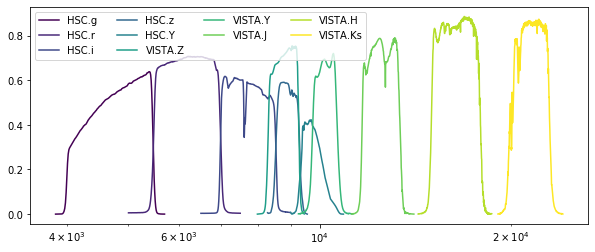

g
r
i
z
Y
Z
Y
J
H
Ks


In [46]:
import numpy as np
from urllib.request import urlretrieve
import os
import matplotlib.pyplot as plt

svo_path = 'http://svo2.cab.inta-csic.es/theory/fps3/getdata.php?format=ascii&id=format=ascii&id={0}'

# filter_names = ['BOK/BASS.g', 'BOK/BASS.r', 'KPNO/MzLS.z',
#                 'UKIRT/UKIDSS.J', 'UKIRT/UKIDSS.K',
#                 'WISE/WISE.W1', 'WISE/WISE.W2']
filter_names = [
    'Subaru/HSC.g',
    'Subaru/HSC.r',
    'Subaru/HSC.i',
    'Subaru/HSC.z',
    'Subaru/HSC.Y',
    'Paranal/VISTA.Z',
    'Paranal/VISTA.Y',
    'Paranal/VISTA.J',
    'Paranal/VISTA.H',
    'Paranal/VISTA.Ks',
]

colors = plt.cm.viridis(np.linspace(0, 1, len(filter_names)))

Fig, Ax = plt.subplots(1,1, figsize=(10, 4))

for i, filt in enumerate(filter_names):
    
    tlscp, name = os.path.split(filt)
    print(filt,tlscp,name)
    filter_lib, info = urlretrieve(svo_path.format(filt), f'data/{name}.dat')

    wave, response = np.loadtxt(f'data/{name}.dat').T

    Ax.semilogx(wave, response, color=colors[i], label=f'{name}')

Leg = Ax.legend(loc='upper left', ncol=4)
plt.show()


output_path = 'data/sxds_filters.res'
combined = open(output_path,'w')
combined_info = open(output_path+'.info','w')
translate = open('data/sxds.translate', 'w')

for ifx, filt in enumerate(filter_names):
    tlscp, name = os.path.split(filt)
    band = name.split('.')[-1]
    data = np.loadtxt(f'data/{name}.dat', ndmin=2, skiprows=0)
    print(band)


    combined.write( '{0:>8d} {1:s} 0 0 0 {2}'.format(int(len(data[:,0])), name, '\n'))
    name_lower=name.lower().replace('.','_')
    translate.write(f'{name_lower:s}_flux F{ifx:.0f}\n')
    translate.write(f'{name_lower:s}_fluxerr E{ifx:.0f}\n')

    nums = range(1,len(data[:,0])+1)
    wave = data[:,0]
    resp = data[:,1]

    worder = np.argsort(wave)
    wave = wave[worder]
    resp = resp[worder]

    for i in range(len(nums)):
        combined.write('{0:>8d} {1:>10.2f} {2:>12.8g} {3}'.format(int(nums[i]), wave[i], resp[i],'\n'))

combined.close()
combined_info.close()
translate.close()

In [52]:
!ls data

HSC.Y.dat
HSC.g.dat
HSC.i.dat
HSC.r.dat
HSC.z.dat
VISTA.H.dat
VISTA.J.dat
VISTA.Ks.dat
VISTA.Y.dat
VISTA.Z.dat
XMM-LSS-specz-v2.91.fits.gz
XMM-LSS.translate
full_reduced_cat_SXDS.fits
lsst_ir_fusion_sxds_photoz_input_20211011.fits
lsst_ir_fusion_sxds_specz_cigale_input_20210906.fits
sxds.translate
sxds.translate.opt
sxds_filters.res
sxds_filters.res.info
testing


In [51]:
!mkdir -p data/testing/all_specz/

In [53]:
!ls data/testing/all_specz/